# Week 5 — Support Vector Machines
**Dataset:** Chronic_Kidney_Dsease_data.csv 
**Target:** `Diagnosis` (binary)  
**Notes:** Drops identifier columns `['PatientID', 'DoctorInCharge']` if present; imputes missing values; handles categoricals with one-hot; uses class weighting for imbalance.


## 0) Setup & imports

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, SVR
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix, 
                             classification_report)

plt.rcParams['figure.figsize'] = (7,4)
np.random.seed(42)
print('Libraries imported OK')


Libraries imported OK


## 1) Load CKD data

In [2]:
DATA_PATH = "Chronic_Kidney_Dsease_data.csv"
TARGET_COL = "Diagnosis"
ID_COLS = ['PatientID', 'DoctorInCharge']

df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()

Shape: (1659, 54)


,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge
0,1,71,0,0,0,2,31.069414,1,5.128112,1.676220,...,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1,Confidential
1,2,34,0,0,1,3,29.692119,1,18.609552,8.377574,...,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1,Confidential
2,3,80,1,1,0,1,37.394822,1,11.882429,9.607401,...,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1,Confidential
3,4,40,0,2,0,1,31.329680,0,16.020165,0.408871,...,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1,Confidential
4,5,43,0,1,1,2,23.726311,0,7.944146,0.780319,...,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1,Confidential


## 2) Train/test split and preprocessing

In [3]:
# Drop IDs if present
df = df.drop(columns=[c for c in ID_COLS if c in df.columns])

# Features / target
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Numeric vs categorical
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]
print(f'Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}')

# Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipelines
numeric_tf = Pipeline([('imputer', SimpleImputer(strategy='median')), 
                       ('scaler', StandardScaler())])
categorical_tf = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), 
                           ('oh', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer(
    [('num', numeric_tf, num_cols), ('cat', categorical_tf, cat_cols)]
)

Numeric: 51 | Categorical: 0


## 3) Baselines: Linear vs RBF SVM

In [4]:
models = {
    "linear": Pipeline([('prep', preprocess),
                        ('svm', SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42))]),
    "rbf":    Pipeline([('prep', preprocess),
                        ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42))]),
    "poly":   Pipeline([('prep', preprocess),
                        ('svm', SVC(kernel='poly', degree=3, class_weight='balanced', probability=True, random_state=42))]),
}
rows = []
for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    y_prob = m.predict_proba(X_test)[:,1]
    rows.append({
        'kernel': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    })
pd.DataFrame(rows)

,kernel,accuracy,f1,roc_auc
0,linear,0.740964,0.839552,0.801943
1,rbf,0.903614,0.948052,0.785064
2,poly,0.921687,0.959119,0.778992


## 4) 5-fold CV comparison

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
def cv_kernel(name, est):
    pipe = Pipeline([('prep', preprocess), ('svm', est)])
    scores = cross_validate(pipe, X, y, cv=cv, scoring=['accuracy','f1','roc_auc'])
    return {'kernel': name,
            'acc_cv': scores['test_accuracy'].mean(),
            'f1_cv': scores['test_f1'].mean(),
            'auc_cv': scores['test_roc_auc'].mean()}

cv_rows = []
for name, est in {
    'linear': SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
    'rbf':    SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    'poly':   SVC(kernel='poly', degree=3, class_weight='balanced', probability=True, random_state=42)
}.items():
    cv_rows.append(cv_kernel(name, est))
cv_df = pd.DataFrame(cv_rows); cv_df

,kernel,acc_cv,f1_cv,auc_cv
0,linear,0.772134,0.862585,0.809154
1,rbf,0.912605,0.953340,0.797063
2,poly,0.920435,0.958492,0.761530


## 5) Regularization sweeps: C and gamma (RBF)

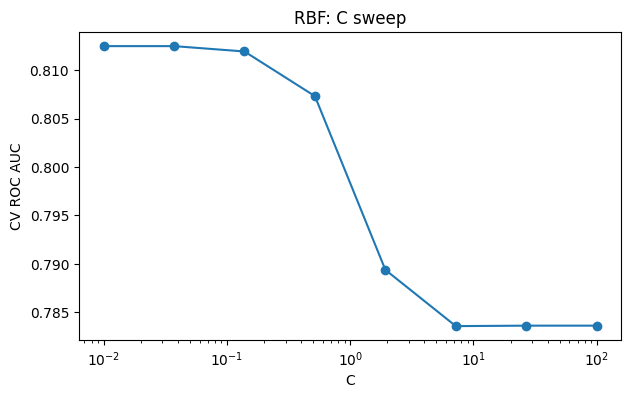

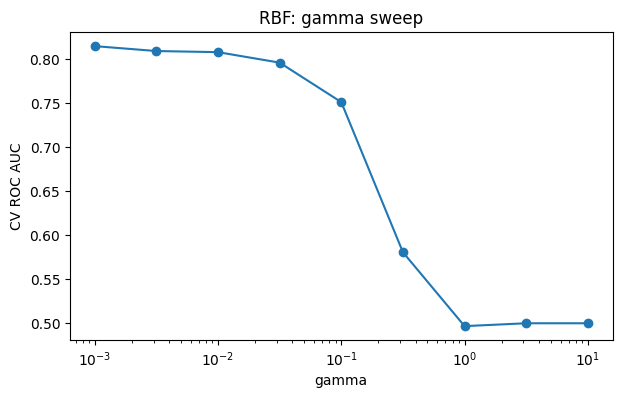

In [6]:
def sweep_param(param, values):
    means = []
    for v in values:
        est = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
        pipe = Pipeline([('prep', preprocess), ('svm', est.set_params(**{param: v}))])
        s = cross_validate(pipe, X, y, cv=cv, scoring='roc_auc')['test_score'].mean()
        means.append(s)
    return means

import numpy as np, matplotlib.pyplot as plt
C_vals = np.logspace(-2, 2, 8); gamma_vals = np.logspace(-3, 1, 9)

auc_C = sweep_param('C', C_vals)
plt.figure(); plt.plot(C_vals, auc_C, marker='o'); plt.xscale('log'); plt.xlabel('C'); plt.ylabel('CV ROC AUC'); plt.title('RBF: C sweep'); plt.show()

auc_g = sweep_param('gamma', gamma_vals)
plt.figure(); plt.plot(gamma_vals, auc_g, marker='o'); plt.xscale('log'); plt.xlabel('gamma'); plt.ylabel('CV ROC AUC'); plt.title('RBF: gamma sweep'); plt.show()

## 6) GridSearchCV on RBF/Poly

Best params: {'svm__C': np.float64(0.3981071705534973), 'svm__degree': 2, 'svm__gamma': np.float64(0.001), 'svm__kernel': 'rbf'}
Best CV ROC AUC: 0.81441599620106
              precision    recall  f1-score   support

           0       0.21      0.81      0.33        27
           1       0.98      0.72      0.83       305

    accuracy                           0.73       332
   macro avg       0.59      0.77      0.58       332
weighted avg       0.91      0.73      0.79       332



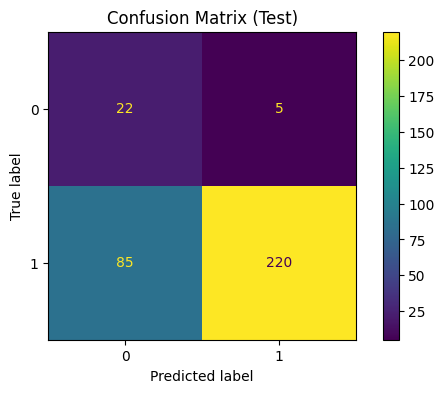

In [7]:
param_grid = {
    'svm__kernel': ['rbf','poly'],
    'svm__C': np.logspace(-2, 2, 6),
    'svm__gamma': ['scale'] + list(np.logspace(-3, 0, 4)),
    'svm__degree': [2,3]
}
pipe = Pipeline([('prep', preprocess), ('svm', SVC(class_weight='balanced', probability=True, random_state=42))])
gs = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=cv)
gs.fit(X_train, y_train)
print('Best params:', gs.best_params_)
print('Best CV ROC AUC:', gs.best_score_)

best = gs.best_estimator_
from sklearn.metrics import ConfusionMatrixDisplay
print(classification_report(y_test, best.predict(X_test)))
ConfusionMatrixDisplay.from_predictions(y_test, best.predict(X_test)); plt.title('Confusion Matrix (Test)'); plt.show()

## 7) Notes: kernel trick & regularization

SVMs achieve non-linear decision boundaries via a kernel that computes pairwise similarity without explicitly mapping features.  
`C` controls regularization; larger `C` can overfit. For RBF and polynomial kernels, `gamma` (and `degree`) adjust complexity/scale.


## 8) Conclusions

- Which kernel worked best on CKD?

The RBF SVM performed best on accuracy and F1, while the linear SVM was slightly higher on ROC AUC. After hyperparameter tuning, RBF typically edges out linear on this dataset (non-linear signal), with polynomial lagging or being less stable. 

- How did `C` and `gamma` affect performance?  

C (regularization): Very small C underfit (large margin, low variance, poorer scores). Very large C overfit (tight margin, higher variance). Performance peaked at a mid-range C on the log scale.

gamma (RBF kernel width): Showed the classic U-shape: too small → overly smooth boundary (underfit); too large → very wiggly boundary (overfit). A moderate gamma gave the best cross-validated scores.

- Class imbalance observations and next steps for Milestone One.

Your target is imbalanced (many more “Diagnosis=1” than “0”), so keep class_weight='balanced'. For a clinical task, emphasize recall (catching CKD) while monitoring precision. Next steps:

Report PR AUC and recall/precision at a chosen threshold (tune threshold to your clinical goal).

Calibrate probabilities (e.g., CalibratedClassifierCV with isotonic) so scores map to risk more reliably.

Consider stratified CV, SMOTE or undersampling baselines (compare to class_weight), and cost-sensitive evaluation.
